# LEVEL 1
# IMPORTING LIBRARIES

In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt

# IMPORT DATA


Number Of Players    :  15
Number Of Images     :  576


Distribution Per Player


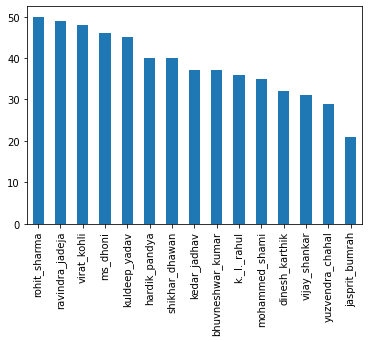

In [2]:
ds = pd.read_csv(r"archive\players.csv")
ds = ds.sample(frac=1).reset_index(drop=True)

le = preprocessing.LabelEncoder()
le.fit(ds['player'])
ds['player_trans'] = le.transform(ds['player'])

n = int(len(ds))
players = ds.player.nunique()
print("Number Of Players    : ",players)
print("Number Of Images     : ",n)
print("\n\nDistribution Per Player")
ds['player'].value_counts().plot.bar()

ds = ds[:-6]
test = ds[-6:]

Distribution Per Player


<AxesSubplot:>

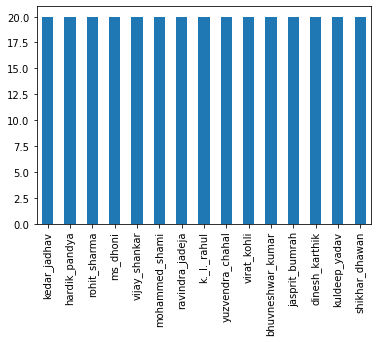

In [3]:
#DISTRIBUTION IS EQUAL IN THIS 

for index,row in ds.iterrows():
    if len(ds[ds['player']==row['player']])>20:
        ds.drop(ds[ds['image']==row['image']].index , inplace=True)

print("Distribution Per Player")
ds['player'].value_counts().plot.bar()

In [4]:
def data_augment(image, label):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:image = tf.image.transpose(image)
    if p_rotate > .75:image = tf.image.rot90(image, k=3) 
    elif p_rotate > .5:image = tf.image.rot90(image, k=2) 
    elif p_rotate > .25:image = tf.image.rot90(image, k=1) 

    if p_pixel_1 >= .4:image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:image = tf.image.random_brightness(image, max_delta=.1)

    if p_crop > .7:
        if p_crop > .9:image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .8:image = tf.image.central_crop(image, central_fraction=.8)
        else:image = tf.image.central_crop(image, central_fraction=.9)
    elif p_crop > .4:
        crop_size = tf.random.uniform([], int(224*.8),224, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, 3])
    
    image = tf.image.resize(image, [224,224])
    return image,label

def load_img(image,player,player_transf):
    path = r"archive\images\\"+player+"\\"+image
    img = tf.io.decode_jpeg(tf.io.read_file(path),channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224,224])
    img = keras.applications.mobilenet_v2.preprocess_input(img)
    return img,player_transf
dataset = tf.data.Dataset.from_tensor_slices((ds.image.values,ds.player.values,ds.player_trans.values))

In [5]:
train_ds = dataset.take(int(0.8*n))
val_ds = dataset.skip(int(0.8*n))
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(load_img,num_parallel_calls = AUTOTUNE)
train_ds = train_ds.repeat(25).map(data_augment,num_parallel_calls = AUTOTUNE)
train_ds = train_ds.batch(25).prefetch(buffer_size = AUTOTUNE)

val_ds = val_ds.map(load_img,num_parallel_calls = AUTOTUNE).batch(25).prefetch(buffer_size = AUTOTUNE)

# DEFINE MODEL

In [6]:
base_model = keras.applications.MobileNetV2(weights = "imagenet",include_top = False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(players , activation = "softmax")(avg)
model = keras.Model(inputs = base_model.input, outputs = output)

for layer in base_model.layers:
    layer.trainable = False

In [7]:
checkpoint_path = r"IMAGE CLASSIFICATION-checkpoint.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

# TRAINING

In [8]:
model.compile(loss = 'sparse_categorical_crossentropy',optimizer = 'adam' , metrics = ["accuracy"])
history = model.fit(train_ds , epochs = 5 , validation_data = val_ds , verbose = 1 , callbacks = [cp_callback])

Epoch 1/5
 13/300 [>.............................] - ETA: 2:27 - loss: 3.1731 - accuracy: 0.1101

KeyboardInterrupt: 

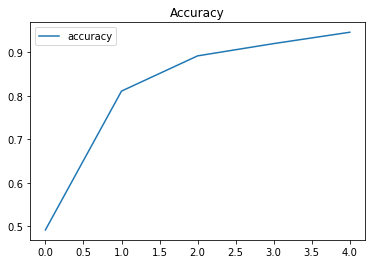

In [18]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history)[['accuracy']].plot()
plt.title("Accuracy")
plt.show()

# TEST CASES

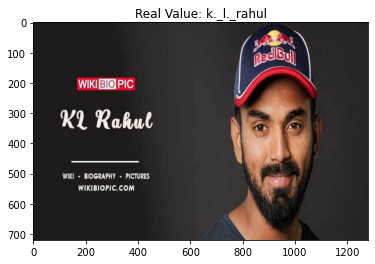

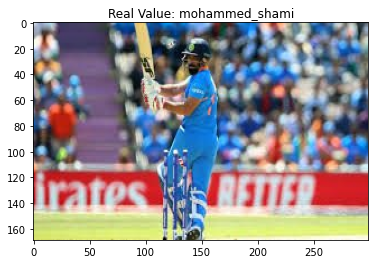

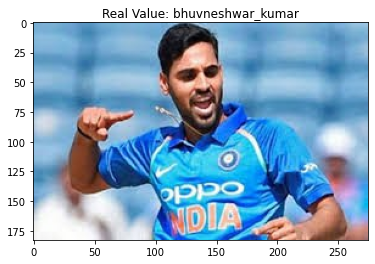

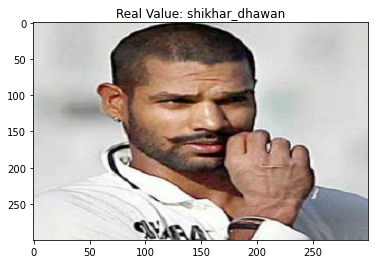

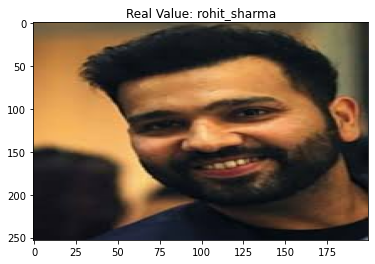

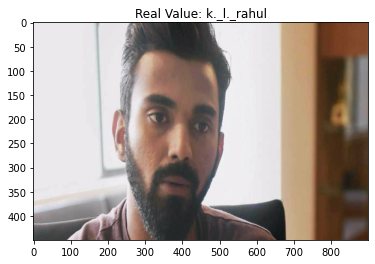

In [19]:
i=0
def load_test_img(image,player,player_transf):
    path = r"archive\images\\"+player+"\\"+image
    img = tf.io.decode_jpeg(tf.io.read_file(path),channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224,224])
    img = keras.applications.mobilenet_v2.preprocess_input(img)
    return img

test_ds = tf.data.Dataset.from_tensor_slices((test.image.values,test.player.values,test.player_trans.values))
test_ds = test_ds.map(load_test_img).batch(6)
prediction = model.predict(test_ds)

for index,row in test.iterrows():
    img = tf.io.decode_jpeg(tf.io.read_file(r"archive\images\\"+row['player']+"\\"+row['image']),channels=3)
    imgplot = plt.imshow(img.numpy().astype("uint8"),aspect='auto')
    real = str(list(le.classes_)[row['player_trans']])
    top_k_values, top_k_indices = tf.nn.top_k(prediction[i], k=3)
    top_k_names = []
    for k in range(3):
        top_k_names+=[str(list(le.classes_)[top_k_indices[k]])]
    plt.title("Real Value: "+str(real))
    plt.show()
    i+=1

# LEVEL 2
# SCRIPT FOR WEBCAM


In [20]:
import cv2
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras

In [31]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)
prefix=r"archive\images\demo"
# while True:
for _ in range(200):
    _,img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 4)
    for(x, y, w, h) in faces:
        
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    cv2.imshow('webcam', img)
    
    k = cv2.waitKey(1000)
    
    if k==ord('c'):
        for i,(x, y, w, h) in enumerate(faces):
            print(i)
            crop = img[y+1:y+h-1,x+1:x+w-1]
            cv2.imwrite(os.path.join(prefix,str(i)+".jpeg"),crop)
    if k==ord('q'):
        break
cap.release()        
cv2.destroyAllWindows()

0


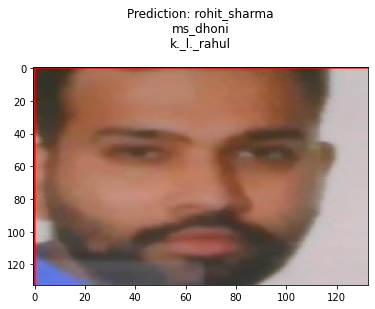

In [32]:
i=0
def load_test_img(image_path):
    path = image_path
    img = tf.io.decode_jpeg(tf.io.read_file(path),channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224,224])
    img = keras.applications.mobilenet_v2.preprocess_input(img)
    return img
test=[r"archive\images\demo\0.jpeg"]
test_ds = tf.data.Dataset.from_tensor_slices(test)
test_ds = test_ds.map(load_test_img).batch(6)
prediction = model.predict(test_ds)
# test_image = load_test_img(r"C:\Users\gupta\Downloads\archive\images\demo\0.jpg")
for index,row in enumerate(test):
#     img = tf.io.decode_jpeg(row,channels=3)
    img = tf.reverse(tf.convert_to_tensor(cv2.imread(row)),[2])
    imgplot = plt.imshow(img.numpy().astype("uint8"),aspect='auto')
#     print(prediction[index,:])
#     real = str(list(le.classes_)[row['player_trans']])
    top_k_values, top_k_indices = tf.nn.top_k(prediction[index,:], k=3)
    top_k_names = []
    title=""
    for k in range(3):
        top_k_names+=[str(list(le.classes_)[top_k_indices[k]])]
        title += top_k_names[k]+"\n"
    plt.title("Prediction: "+title)
    plt.show()
    i+=1